### Biased Mean Variance Objective with Elastic Net Penalty Solved via Split Bregman 


In [1]:
import sys
import itertools
import numpy as np
import pandas as pd
from scipy.optimize import minimize, Bounds, LinearConstraint
from qpsolvers import solve_qp
from scipy.sparse import csc_matrix
import matplotlib.pyplot as plt

path='/home/jbohn/jupyter/personal/L1_Portfolio_Opt'
sys.path.append(path)

from Features.features import load_features
from Parameter_Estimation.bias_mean import reg_mean
from Parameter_Estimation.bias_cov import reg_cov

### Prep and Load Equity Data 

In [2]:
train_data,test_data=load_features(0.5)
train_data.head()

,MMM,AOS,ABT,ABBV,ABMD,ACN,ATVI,ADM,ADBE,ADP,...,WTW,GWW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-05,-0.006283,-0.012860,-0.008112,0.0,-0.024321,0.006161,0.001768,0.005387,0.016313,-0.005385,...,-0.002244,0.000411,0.059041,-0.011930,0.0,-0.003426,-0.001745,0.031165,0.034651,0.0
2010-01-06,0.014082,0.000454,0.005538,0.0,-0.015358,0.010575,-0.005314,-0.002532,-0.002124,-0.002350,...,0.015971,0.003796,-0.013204,0.001919,0.0,-0.007175,-0.007717,-0.000323,0.083382,0.0
2010-01-07,0.000717,0.002946,0.008250,0.0,0.000000,-0.000935,-0.024271,-0.010511,-0.019595,-0.000471,...,-0.002952,0.009377,0.021131,-0.004322,0.0,-0.000288,-0.025318,0.022681,0.106160,0.0
2010-01-08,0.007022,0.014602,0.005099,0.0,-0.020446,-0.003986,-0.008223,-0.012567,-0.005436,-0.001414,...,-0.001109,0.011700,-0.007191,0.000481,0.0,0.000288,-0.003256,-0.021228,-0.016320,0.0
2010-01-11,-0.004040,-0.004694,0.005073,0.0,-0.018394,-0.000940,-0.000918,0.000648,-0.013169,0.004469,...,0.009939,0.004203,-0.003245,0.009574,0.0,0.017133,0.003256,0.021860,0.006075,0.0


### Mean and covariance estimation from sample

In [3]:
returns_mean=train_data.mean().values
returns_cov=np.cov(train_data.T)

Text(0, 0.5, 'Freq')

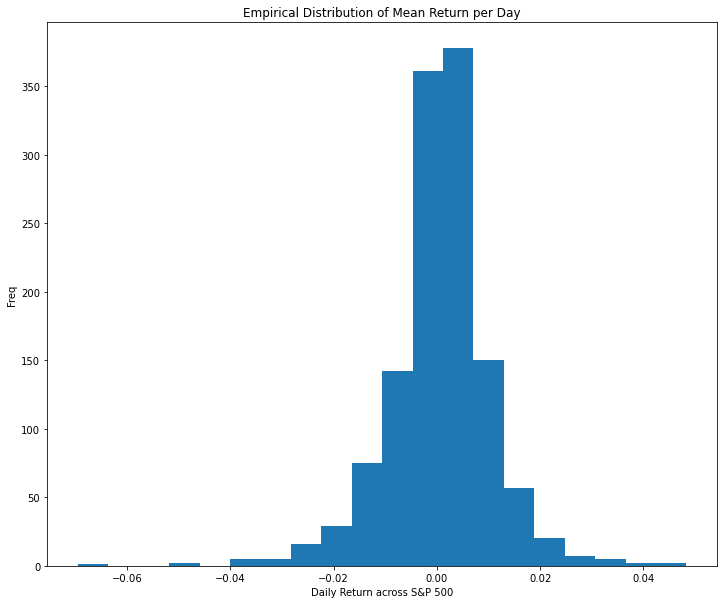

In [4]:
fig,ax=plt.subplots(figsize=(12,10))
bins=plt.hist(train_data.mean(axis=1),bins=20)
plt.title("Empirical Distribution of Mean Return per Day")
plt.xlabel("Daily Return across S&P 500")
plt.ylabel("Freq")

Text(0.5, 1.0, 'Singular Values of Covariance Matrix')

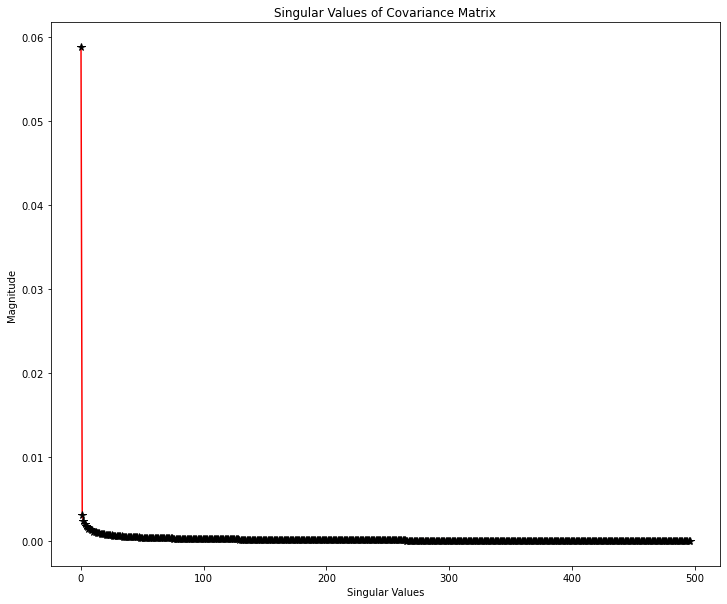

In [5]:
u,s,v=np.linalg.svd(returns_cov)
fig,ax=plt.subplots(figsize=(12,10))
bins=plt.plot(s,marker='*',color='red',markersize=7.5,mfc='black',mec='black')
plt.xlabel('Singular Values')
plt.ylabel('Magnitude')
plt.title("Singular Values of Covariance Matrix")

### Regularized Mean and Covariance Estimators 

In [6]:
biased_mean=reg_mean(returns_mean)

biased_cov=reg_cov(returns_cov)

### Application of Sparse Solver Split Bregman Operator

Utilizes nested optimization routine where
- Inner Optimization is unconstrained QP problem involving L2 penalty
    - Can solve numerically via constrained minimization and box constraints
    - Solve analytically via closed form solution
- Applies shrinkage (L1) penalty within outer loop


Interesting results in normalization of w vector

In [21]:
def qp(cov,mean,w,d,b,lb,ub,lambda2,approach,tol=10e-6,maxiter=25,verbose=True):
    """ Inner optimization problem using unconstrained optimization 
        Approach "numerical" solves numerically via unconstrained minimization
        Approach "closed-form" solves analytically via cvxopt within qpsolvers 
        Support for standard mean variance optimization (approach=2; pen=False)
    """
    
    # reinitialize unit starting point randomly to not get stuck in local minima
    x0=w
    

    status=None

    if approach=="numerical":
        def objective_val(w,cov,mean,d,b,lambda2):
            obj=np.dot(np.dot(w,cov+lambda2*np.diag(d-b)),w)-np.dot(w,mean)
            
            return obj
        bounds=Bounds(lb,ub)
        lc=LinearConstraint(np.ones(len(mean)),1,1)
        res=minimize(objective_val,x0=x0,args=(cov,mean,d,b,lambda2),method='SLSQP',bounds=bounds,constraints=lc,options={'maxiter':maxiter},tol=tol)
        w=res.x
        status=res.status
        
    if approach=="closed-form":
        w_old=w
        
        # define objective function with l2 penalty
        quad=csc_matrix((cov+lambda2*np.diag(d-b)))
        linear=-1*mean
        
        # constrain solution vector to be unit norm and non-negative
        A=np.ones(len(mean))
        constraint=np.array([1.0])

        # set box constraints
        lb_vec=lb*np.ones(len(mean))
        ub_vec=ub*np.ones(len(mean))

        w = solve_qp(quad,linear.reshape(len(linear),),A=A,b=constraint,initvals=x0, lb=lb_vec,ub=ub_vec,solver="cvxopt")
        status="solved"

        if w is None:
            print("QP Optimization fails, Trying again")
            status="failed"
            return w_old,status
    return w,status

def shrinkage(w,b,lambda1,beta):
    """ Applies one-sided soft-thresholding operator that is equivalent to L1 penalization 
    """
    
    if lambda1==0:
        return np.zeros(len(w))
    x=beta*w+b
    obj=np.fmax([np.abs(x)-(1/lambda1)],[np.zeros(len(w))])  
    signed_obj=np.sign(x)*obj

    return signed_obj[0]

def split_bregman(cov,mean,lambda1,lambda2,lb,ub,beta=None,tol=1e-10,maxiter=100,approach=2,verbose=True):
    """ Split Bregman Optimization Routine
    """

    total_cost=1
    n=len(mean)
    if beta is None:
        beta=np.ones(n)
    
    b=np.zeros(n)
    w=np.random.rand(n)
    w=w/np.linalg.norm(w,ord=1)
    d=np.zeros(n)
    
    i=0
    while total_cost>tol:
        if i>maxiter:
            if verbose:
                print("MaxIter Achieved")
            break
        
        # solve qp problem either closed form or numerically
        w,status=qp(cov,mean,w,d,b,lb,ub,lambda2,approach,tol,maxiter,verbose)
        
        if status=="failed":
            w=w_old
            break
 
        # solve for sparse vector near previous optimal solution
        d=shrinkage(w,b,lambda1,beta)
        b=b+beta*w -d 
        i+=1

        # compute total cost
        total_cost=np.dot(np.dot(w,cov),w)-np.dot(w,mean)+(lambda1*np.sum(np.abs(w))+lambda2*np.sum((w)**2))/2
        if verbose:
            print(f"Total Cost: {total_cost}")
        
        w_old=w

    if sum(abs(w))==0:
        return w,total_cost

    return w, total_cost

### Numerical Results

Unit Tests
- Solve for the optimal solution both via closed form solution and numerically via minimization 
- Compare optimal objective values and solution


### Test 1: Equal Penalties Closed Form and Numerically

In [22]:
lambda1=10
lambda2=10
w_numerical,error_numerical=split_bregman(biased_cov,biased_mean,lb=-0.05,ub=0.1,lambda1=lambda1,lambda2=lambda2,tol=1e-6,maxiter=25,approach="numerical",verbose=True)
w_numerical

Total Cost: 5.010864493121129
Total Cost: 5.010864493121129
Total Cost: 5.0109958965398835
Total Cost: 5.0109958965398835
Total Cost: 5.011250334954815
Total Cost: 5.012357396348641
Total Cost: 5.013506720649527
Total Cost: 5.015193150712365
Total Cost: 5.017517791430888
Total Cost: 5.053258016834011
Total Cost: 5.206004358757582
Total Cost: 5.299897051819779
Total Cost: 6.296568807959731
Total Cost: 8.491519223851244
Total Cost: 6.360759247600042
Total Cost: 14.273921682977436
Total Cost: 6.634021235009368
Total Cost: 14.017082669408692
Total Cost: 5.63397795682822
Total Cost: 17.170795316966245
Total Cost: 5.596280768640836
Total Cost: 17.16801219381819
Total Cost: 5.515112377252176
Total Cost: 17.168670725968845
Total Cost: 5.49352607632862
Total Cost: 17.169379089616285
MaxIter Achieved


array([-2.18300644e-03, -3.31843318e-03, -2.14473694e-03, -2.19581383e-03,
       -4.07937335e-03, -2.20830964e-03, -2.15612001e-03, -2.12437776e-03,
       -2.18578558e-03, -2.23703094e-03, -3.90707104e-03, -2.06516036e-03,
       -2.07698556e-03, -2.15534756e-03, -2.14027984e-03, -2.27275373e-03,
       -4.94414705e-04, -2.11853072e-03, -2.09631707e-03, -2.48229043e-03,
       -2.08208952e-03, -2.23084922e-03, -2.24143496e-03, -2.14023455e-03,
       -2.13882346e-03, -2.35605640e-03, -2.26896360e-03, -2.11473063e-03,
       -2.19161868e-03, -2.12493233e-03,  1.00000000e-01, -2.13626251e-03,
       -2.22749162e-03, -2.14499910e-03, -2.25416256e-03, -2.29204388e-03,
       -2.61640070e-03, -3.12573237e-03, -2.54489607e-03, -2.44467600e-03,
       -2.24400196e-03, -2.15217468e-03, -2.16264862e-03, -2.31841057e-03,
       -2.10166652e-03, -3.36780883e-03, -2.14914884e-03, -3.33529793e-03,
       -2.32779417e-03, -2.08120892e-03, -2.21649278e-03, -2.23257304e-03,
       -2.07063485e-03, -

In [23]:
lambda1=1
lambda2=1
w_cf,error_cf=split_bregman(biased_cov,biased_mean,lb=-0.05,ub=0.1,lambda1=lambda1,lambda2=lambda2,tol=1e-6,maxiter=25,approach="closed-form",verbose=True)
w_cf

Total Cost: 0.5036532816684033
Total Cost: 0.5036903478534912
Total Cost: 0.5037275710091168
Total Cost: 0.5037649587481677
Total Cost: 0.503802519175406
Total Cost: 0.5038402609269681
Total Cost: 0.5038781932140627
Total Cost: 0.5039163258714319
Total Cost: 0.5039546694112336
Total Cost: 0.5039932350830999
Total Cost: 0.5040320349412777
Total Cost: 0.5040710819198954
Total Cost: 0.5041103899176047
Total Cost: 0.5041499738930707
Total Cost: 0.504189849973072
Total Cost: 0.5042300355753143
Total Cost: 0.5042705495485017
Total Cost: 0.5043114123327374
Total Cost: 0.5043526461439936
Total Cost: 0.5043942751872487
Total Cost: 0.504436325903949
Total Cost: 0.5044788272608254
Total Cost: 0.5045218110888813
Total Cost: 0.5045653124836511
Total Cost: 0.5046093702808737
Total Cost: 0.5046540276257343
MaxIter Achieved


array([ 0.00187386,  0.00318132,  0.00165564,  0.00184915,  0.00348184,
        0.00200874,  0.00169266,  0.00152746,  0.00182867,  0.0021121 ,
        0.00334373,  0.00061608,  0.00101492,  0.00164489,  0.00161427,
        0.00222067,  0.00458938,  0.00138305,  0.00120359,  0.00266274,
        0.000962  ,  0.00210458,  0.002174  ,  0.00157747,  0.00156612,
        0.00239056,  0.00216294,  0.0014127 , -0.00142749,  0.0015783 ,
        0.00591169,  0.0016749 ,  0.00211689,  0.00169508,  0.00216717,
        0.0022618 ,  0.00284072,  0.00300853,  0.00272202,  0.00256702,
        0.0021647 ,  0.00162072,  0.00171312,  0.00234644, -0.00025556,
        0.00313674,  0.00159618,  0.00306121,  0.00234945,  0.00090218,
        0.00201571,  0.00213479,  0.00095894,  0.00180875,  0.00212223,
        0.00336646,  0.00191033,  0.00120407,  0.00111776,  0.00242585,
        0.00077355,  0.00358094,  0.00105832,  0.00169295,  0.0020105 ,
        0.00057145,  0.00099947,  0.00116866,  0.00444479,  0.00

### Comparisons of Optimal Solution

In [24]:
cutoff_threshold=0.001

Text(0, 0.5, 'Weight Allocation')

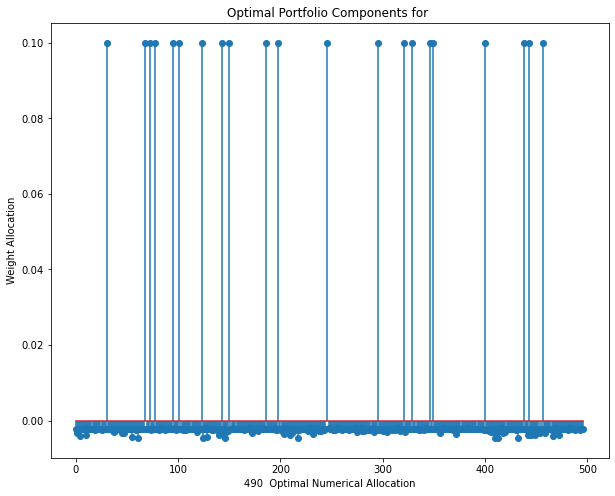

In [25]:
optimal_numerical=np.where(abs(w_numerical)>cutoff_threshold)[0]
fig,ax=plt.subplots(figsize=(10,8))
plt.title("Optimal Portfolio Components for ")
ax.stem(optimal_numerical,w_numerical[optimal_numerical],markerfmt='o',use_line_collection=True)
ax.set_xlabel(f"{len(optimal_numerical)}  Optimal Numerical Allocation")
ax.set_ylabel("Weight Allocation")

Text(0, 0.5, 'Weight Allocation')

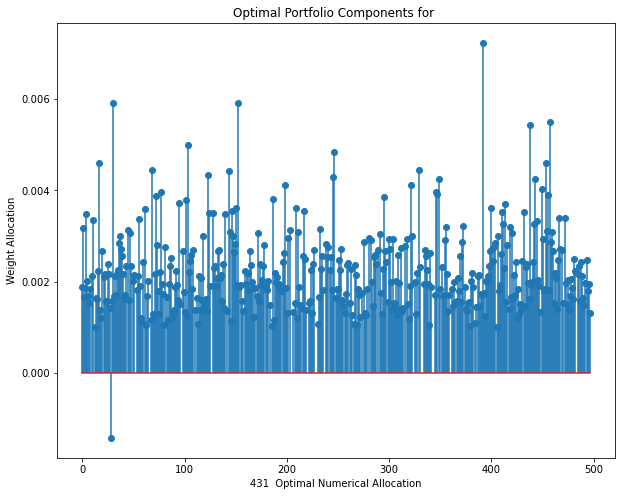

In [26]:
optimal_cf=np.where(abs(w_cf)>cutoff_threshold)[0]
fig,ax=plt.subplots(figsize=(10,8))
plt.title("Optimal Portfolio Components for ")
ax.stem(optimal_cf,w_cf[optimal_cf],markerfmt='o',use_line_collection=True)
ax.set_xlabel(f"{len(optimal_cf)}  Optimal Numerical Allocation")
ax.set_ylabel("Weight Allocation")

### Grid Search for Optimal Lambda Values 
- Cross valaidate optimal $\lambda_1$ and $\lambda_2$ parameters representing L1 and L2 regularization

In [27]:
def grid_search(params,returns_mean,returns_cov,tol=1e-8,maxiter=25):
    """ Grid Search for optimal lambda1 and lambda2 under constrained portfolio problem 
    """
    results={}
    for i in params:
        lambda1,lambda2=i
        lb,ub=0,1
        w,error=split_bregman(returns_cov,returns_mean,lambda1,lambda2,lb=lb,ub=ub,tol=tol,maxiter=maxiter,approach="closed-form",verbose=False)
        print(f" lambda1: {np.round(lambda1,4)} lambda2: {np.round(lambda2,4)} error: {np.round(error,8)}")
        results[i]=(w,error)
    sorted_dict=sorted(results.items(), key=lambda x:x[1][1])
    return sorted_dict

lambda1_grid=np.geomspace(0.0001,100,5)
lambda2_grid=np.geomspace(0.0001,100,5)

params=[]
for i in itertools.product(lambda1_grid,lambda2_grid):
    params.append(i)

sorted_dict=grid_search(params,biased_mean,biased_cov)

 lambda1: 0.0001 lambda2: 0.0001 error: 0.0005255
 lambda1: 0.0001 lambda2: 0.0032 error: 0.00052912
 lambda1: 0.0001 lambda2: 0.1 error: 0.0006443
QP Optimization fails, Trying again
 lambda1: 0.0001 lambda2: 3.1623 error: 0.00680613
QP Optimization fails, Trying again
 lambda1: 0.0001 lambda2: 100.0 error: 0.11550339
 lambda1: 0.0032 lambda2: 0.0001 error: 0.00205664
 lambda1: 0.0032 lambda2: 0.0032 error: 0.00206026
 lambda1: 0.0032 lambda2: 0.1 error: 0.00217543
QP Optimization fails, Trying again
 lambda1: 0.0032 lambda2: 3.1623 error: 0.00833727
QP Optimization fails, Trying again
 lambda1: 0.0032 lambda2: 100.0 error: 0.11703453
 lambda1: 0.1 lambda2: 0.0001 error: 0.0504755
 lambda1: 0.1 lambda2: 0.0032 error: 0.05047912
 lambda1: 0.1 lambda2: 0.1 error: 0.0505943
QP Optimization fails, Trying again
 lambda1: 0.1 lambda2: 3.1623 error: 0.05675613
QP Optimization fails, Trying again
 lambda1: 0.1 lambda2: 100.0 error: 0.16545339
 lambda1: 3.1623 lambda2: 0.0001 error: 1.58161433

Text(0, 0.5, 'Weight Allocation')

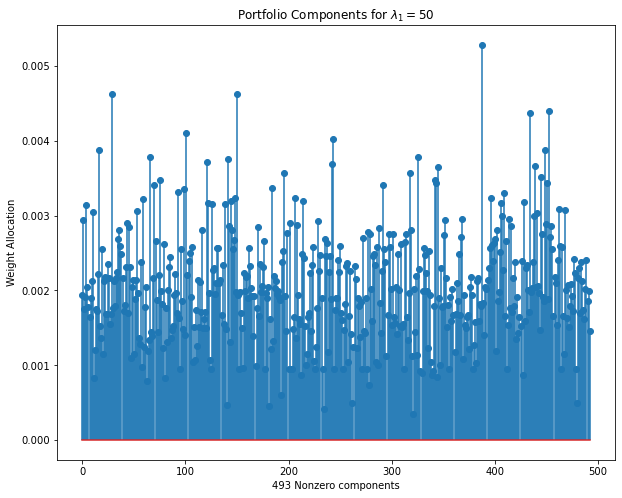

In [29]:
wi=sorted_dict[0][1][0]
nonzero_wi=np.where(abs(wi)>0.0001)[0]

fig,ax=plt.subplots(figsize=(10,8))
plt.title("Portfolio Components for $\lambda_1=50$")
ax.stem(wi[nonzero_wi])
plt.xlabel(f"{len(wi[nonzero_wi])} Nonzero components")
plt.ylabel("Weight Allocation")

In [30]:
print(f"Largest Component is {max(abs(wi[nonzero_wi]))}")
print(f"Smallest Component is {min(abs(wi[nonzero_wi]))}")

Largest Component is 0.005287348934712082
Smallest Component is 0.00034467562829224133
